# EpiPINN

Physics-informed neural network learning epidemiological parameters

### Antonio Jimenez AOJ268
### Ashton Cole AVC687

## Contents

- Definitions
- Experiments
    - Experiment 1: Parameter estimation with exact data
    - Experiment 2: Parameter estimation with noisy data
    - Experiment 3: Parameter estimation and forecasting with noisy limited data

## Definitions

In [1]:
from caputo import caputo_euler
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
class PINN(nn.Module):
    def __init__(self, hidden_size, depth):
        super().__init__()
        # input t
        layers = [nn.Linear(1, hidden_size), nn.Tanh()]
        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        # Output layer with 5 units for (s, e, i, r, d)
        layers.append(nn.Linear(hidden_size, 5))
        # Add softmax to enforce all components are positive and sum to 1
        layers.append(nn.Softmax(dim=1))
        
        self.net = nn.Sequential(*layers)

    def forward(self, t):
        return self.net(t)

In [3]:
def caputo_l1_diff(psi, alpha, dt):
    n = len(psi)
    # The derivative at t=0 is undefined for the L1 scheme
    derivatives = [torch.zeros(1, 1, device=psi.device)] 
    
    # Pre-compute the log of the gamma function part for stability
    log_gamma_term = torch.lgamma(2.0 - alpha)

    for i in range(1, n):
        # Make vector of k values from 0 to i-1
        k = torch.arange(i, dtype=torch.float32, device=psi.device)
        
        # Calculate weights c_k^(i) 
        weights = ((k + 1)**(1 - alpha) - k**(1 - alpha))
        
        # Get the differences psi(t_{i-k}) - psi(t_{i-k-1})
        psi_diffs = psi[i - k.long()] - psi[i - k.long() - 1]
        
        summation = torch.sum(weights * psi_diffs.squeeze())
        
        # Combine everything to get the derivative at time t_i
        deriv_at_i = (1.0 / (dt**alpha * torch.exp(log_gamma_term))) * summation
        derivatives.append(deriv_at_i.unsqueeze(0))
        
    return torch.cat(derivatives).unsqueeze(1)

In [4]:
class EpiPINN(nn.Module):
    def __init__(self, hidden_size, depth, initial_params):
        super().__init__()
        
        self.pinn = PINN(hidden_size, depth) 
        # trainable params
        # x + torch.log(-torch.expm1(-x))
        self.raw_beta = nn.Parameter(torch.tensor([initial_params['beta'] + np.log(-np.expm1(-initial_params['beta']))], dtype=torch.float32))
        self.raw_sigma = nn.Parameter(torch.tensor([initial_params['sigma'] + np.log(-np.expm1(-initial_params['sigma']))], dtype=torch.float32))
        self.raw_gamma = nn.Parameter(torch.tensor([initial_params['gamma'] + np.log(-np.expm1(-initial_params['gamma']))], dtype=torch.float32))
        self.raw_mu = nn.Parameter(torch.tensor([initial_params['mu'] + np.log(-np.expm1(-initial_params['mu']))], dtype=torch.float32))
        # Init z_alpha such that the init alpha is close to 1.0
        self.z_alpha = nn.Parameter(torch.tensor([initial_params['z_alpha']], dtype=torch.float32)) # sigmoid(2.94) is approx 0.95
        
        self.min_alpha = initial_params['min_alpha'] # Example minimum value for alpha
        self.dt = initial_params['dt']

    def beta(self):
        return nn.functional.softplus(self.raw_beta)

    def sigma(self):
        return nn.functional.softplus(self.raw_sigma)

    def gamma(self):
        return nn.functional.softplus(self.raw_gamma)
        
    def mu(self):
        return nn.functional.softplus(self.raw_mu)

    def alpha(self):
        # Restrict alpha to a specific range, (min_alpha, 1.0] 
        return self.min_alpha + (1.0 - self.min_alpha) * torch.sigmoid(self.z_alpha)
    
    def forward(self, t):
        return self.pinn(t)

    def get_loss_ic(self, ts, ic, y_pred=None):
        """Get initial condition loss of model.

        Arguments:
            ts (torch.tensor): Time points for the model, assuming t[0] is the initial time. Only t[0] is needed, but the tensor dimensions must be consistent.
            ic (torch.tensor): The initial state to enforce.
            y_pred=None (torch.tensor): Predictions at time points, if already computed. Only y[0] is needed, but the tensor dimensions must be consistent.

        Returns:
            squared l2 norm of initial condition error
        """
        # IC loss
        t_initial = ts[0].unsqueeze(0) # get t_0
        y_initial_pred = self.forward(t_initial) if y_pred == None else y_pred[0, :].unsqueeze(0)
        return nn.functional.mse_loss(y_initial_pred, ic)

    def get_loss_data(self, t_data, y_data, y_data_pred=None):
        """Get data loss of model.

        Arguments:
            t_data (torch.tensor): Training data times.
            y_data (torch.tensor): Corresponding state data.
            y_data_pred=None (torch.tensor): Predictions at data points, if already computed.

        Returns:
            MSE loss (squared l2 norm) of data error
        """
        # Data Loss
        y_data_pred = self.forward(t_data) if y_data_pred == None else y_data_pred
        return nn.functional.mse_loss(y_data_pred, y_data)

    def get_loss_phys(self, t_colloc, y_colloc_pred=None):
        """Get physics loss of model.

        Arguments:
            t_colloc (torch.tensor): Times at which to compute the loss.
            y_colloc_pred=None (torch.tensor): Predictions at collocation points, if already computed.

        Returns:
            squared l2 norm of residual
        """
        # Phys Loss
        y_colloc_pred = self.forward(t_colloc)
        s,e,i,r,d = y_colloc_pred.unbind(1)
        ds_dt = caputo_l1_diff(s, self.alpha(), self.dt)
        de_dt = caputo_l1_diff(e, self.alpha(), self.dt)
        di_dt = caputo_l1_diff(i, self.alpha(), self.dt)
        dr_dt = caputo_l1_diff(r, self.alpha(), self.dt)
        dd_dt = caputo_l1_diff(d, self.alpha(), self.dt)

        # calculate RHS of equation 4
        num_living =  1 - d
        f_s = -self.beta() * s * i / num_living
        f_e = (self.beta() * s * i / num_living) - self.sigma() * e
        f_i = (self.sigma() * e) - (self.gamma()+ self.mu()) * i
        f_r = self.gamma() * i
        f_d = self.mu() * i

        # calc residuals (LHS - RHS = 0)
        residual_s = ds_dt - f_s
        residual_e = de_dt - f_e
        residual_i = di_dt - f_i
        residual_r = dr_dt - f_r
        residual_d = dd_dt - f_d

        all_residuals = torch.cat([residual_s, residual_e, residual_i, residual_r, residual_d], dim=1)
        loss_phys = torch.mean(all_residuals**2)
        return loss_phys

In [31]:
def train_stage1(model, ts, ys, t_colloc, ic, optimizer, epochs=1000, pr=0):
    """Stage one of EpiPINN training process.

    In this stage, only the weights of the neural network are trained to minimize the data and initial condition loss.

    Arguments:
        model (EpiPINN): An instantiated fractional SEIRD model to train.
        ts (torch.tensor): Time values for time-series data.
        ys (torch.tensor): States (s, e, i, r, d) for time-series data.
        optimizer: Pytorch training optimizer.
        epochs=1000 (Int): How many epochs to perform gradient descent.
        pr=0 (Int): Print progress every pr epochs. If 0, nothing is printed.

    Returns:
        losses, losses_data, losses_ic, losses_phys
    """
    losses = []
    losses_data = []
    losses_ic = []
    losses_phys = []

    # Ensure epidemiological parameters are not trained
    model.raw_beta.requires_grad = False
    model.raw_sigma.requires_grad = False
    model.raw_gamma.requires_grad = False
    model.raw_mu.requires_grad = False
    model.z_alpha.requires_grad = False

    # Set to training mode
    model.train()

    for epoch in range(epochs):
        predictions = model(ts)
        
        # Compute losses separately, then combine
        loss_data = model.get_loss_data(ts, ys, y_data_pred=predictions)
        loss_ic = model.get_loss_ic(t_colloc, ic, y_pred=predictions)
        loss_phys = 100 * model.get_loss_phys(t_colloc)
        loss = loss_data + loss_ic # Physics is not used for gradient descent

        # Record losses
        losses.append(loss.item() + loss_phys.item()) # Physics is recored, not mimimized
        losses_data.append(loss_data.item())
        losses_ic.append(loss_ic.item())
        losses_phys.append(loss_phys.item())

        # Adjust weights to minimize loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress if desired
        if pr != 0 and (epoch + 1) % pr == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}')
    
    # Set to evaluation mode
    model.eval()
        
    return losses, losses_data, losses_ic, losses_phys

In [32]:
def train_stage2(model, ts, ys, t_colloc, ic, optimizer, epochs=1000, pr=0):
    """Stage two of EpiPINN training process.

    In this stage, both the weights of the neural network and epidemiological parameters are trained to minimize the data, initial condition, and physics losses.

    Arguments:
        model (EpiPINN): An instantiated fractional SEIRD model to train.
        ts (torch.tensor): Time values for time-series data.
        ys (torch.tensor): States (s, e, i, r, d) for time-series data.
        optimizer: Pytorch training optimizer.
        epochs=1000 (Int): How many epochs to perform gradient descent.
        pr=0 (Int): Print progress every pr epochs. If 0, nothing is printed.

    Returns:
        losses, losses_data, losses_ic, losses_phys, alphas, betas, sigmas, gammas, mus
    """
    losses = []
    losses_data = []
    losses_ic = []
    losses_phys = []
    alphas = []
    betas = []
    sigmas = []
    gammas = []
    mus = []

    # Ensure epidemiological parameters are trained
    model.raw_beta.requires_grad = True
    model.raw_sigma.requires_grad = True
    model.raw_gamma.requires_grad = True
    model.raw_mu.requires_grad = True
    model.z_alpha.requires_grad = True

    # Set to training mode
    model.train()

    for epoch in range(epochs):
        predictions = model(ts)
        
        # Compute losses separately, then combine
        loss_data = model.get_loss_data(ts, ys, y_data_pred=predictions)
        loss_ic = model.get_loss_ic(t_colloc, ic, y_pred=predictions)
        loss_phys = 100 * model.get_loss_phys(t_colloc)
        loss = loss_data + loss_ic + loss_phys

        # Record losses
        losses.append(loss.item())
        losses_data.append(loss_data.item())
        losses_ic.append(loss_ic.item())
        losses_phys.append(loss_phys.item())

        # Record epidemiological parameters
        alphas.append(model.alpha().item())
        betas.append(model.beta().item())
        sigmas.append(model.sigma().item())
        gammas.append(model.gamma().item())
        mus.append(model.mu().item())

        # Adjust weights to minimize loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress if desired
        if pr != 0 and (epoch + 1) % pr == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}')

    # Set to evaluation mode
    model.eval()
    
    return losses, losses_data, losses_ic, losses_phys, alphas, betas, sigmas, gammas, mus

## Experiments

### Experiment 1: Parameter estimation with exact data

This experiment is a recreation of the Mpox synthetic case found in the paper. We were unable to find the synthetic time series data $(s, e, i, r, d)(t)$ from the cited source, so we instead implemented a fractional ODE solver to generate data consistent with the provided epidemiological parameters.

In [42]:
# Data generation
alpha_true = 0.95 # Derivative fraction used for data
beta_true = 0.25 # Infection rate used for model
sigma_true = 0.13 # Incubation rate used for model
gamma_true = 0.052 # Recovery rate used for model
mu_true = 0.005 # Death rate used for model
y0 = np.array([0.99, 0.01, 0, 0, 0]) # Initial state: 1% exposed
t0 = 0
tf = 500 # 500 days
num_step = 200 # Good ground truth from tests

f = lambda t, y: np.array([
    - beta_true * (y[0] * y[3]) / (1 - y[4]),
    beta_true * (y[0] * y[3]) / (1 - y[4]) - sigma_true * y[1],
    sigma_true * y[1] - (gamma_true + mu_true) * y[2],
    gamma_true * y[2],
    mu_true * y[2]
])

ts, ys = caputo_euler(f, alpha_true, (t0, tf), num_step, y0)

ts_train = torch.tensor(ts.reshape(-1, 1), dtype=torch.float32)
ys_train = torch.tensor(ys, dtype=torch.float32)

In [43]:
# Define model
min_alpha_guess = 0.9 # Mimimum searched derivative fraction
alpha_guess = 0.95 # Derivative fraction used for model
scaled_alpha_guess = (alpha_guess - min_alpha_guess) / (1.0 - min_alpha_guess) # Rescaling for search set to match range of sigmoid (0, 1)
z_alpha_guess = np.log(scaled_alpha_guess / (1 - scaled_alpha_guess)) # Inverse sigmoid
beta_guess = 0.25 # Infection rate used for model
sigma_guess = 0.13 # Incubation rate used for model
gamma_guess = 0.052 # Recovery rate used for model
mu_guess = 0.005 # Death rate used for model
hidden_size = 64 # Number of neurons per layer
depth = 3 # Number of layers
ts_colloc = torch.from_numpy(np.linspace(t0, tf, 400)).float().unsqueeze(1)
initial_params = {
    "z_alpha": z_alpha_guess,
    "min_alpha": min_alpha_guess,
    "beta": beta_guess,
    "sigma": sigma_guess,
    "gamma": gamma_guess,
    "mu": mu_guess,
    "dt": (tf - t0) / num_step
}
ic = torch.tensor(y0, dtype=torch.float32).unsqueeze(0)

model1 = EpiPINN(hidden_size, depth, initial_params)

In [44]:
# Load model if already generated

In [45]:
# Start timing
start1 = time.time()

# Stage 1: weights only, without considering physics in updates
losses1, losses1_data, losses1_ic, losses1_phys = train_stage1(
    model1,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model1.parameters(), lr=1e-2),
    epochs=2000,
    pr=100
)

# Stop timing
stop1 = time.time()
print(f'Complete in {stop1 - start1} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model1.alpha().item()}')
print(f'beta = {model1.beta().item()}')
print(f'gamma = {model1.gamma().item()}')
print(f'sigma = {model1.sigma().item()}')
print(f'mu = {model1.mu().item()}')

Epoch [100/2000], Loss: 0.001970
Epoch [200/2000], Loss: 0.000787
Epoch [300/2000], Loss: 0.000036
Epoch [400/2000], Loss: 0.000218
Epoch [500/2000], Loss: 0.000032
Epoch [600/2000], Loss: 0.000285
Epoch [700/2000], Loss: 0.000041
Epoch [800/2000], Loss: 0.000009
Epoch [900/2000], Loss: 0.000020
Epoch [1000/2000], Loss: 0.000011
Epoch [1100/2000], Loss: 0.000011
Epoch [1200/2000], Loss: 0.000012
Epoch [1300/2000], Loss: 0.000002
Epoch [1400/2000], Loss: 0.000247
Epoch [1500/2000], Loss: 0.000003
Epoch [1600/2000], Loss: 0.000002
Epoch [1700/2000], Loss: 0.000003
Epoch [1800/2000], Loss: 0.000004
Epoch [1900/2000], Loss: 0.000049
Epoch [2000/2000], Loss: 0.000002
Complete in 150.11179995536804 seconds
alpha = 0.949999988079071
beta = 0.25
gamma = 0.05199999734759331
sigma = 0.12999999523162842
mu = 0.004999999888241291


In [46]:
# Start timing
start2 = time.time()

# Stage 2: weights and epidemiological parameters, considering full loss
losses2, losses2_data, losses2_ic, losses2_phys, alphas, betas, sigmas, gammas, mus = train_stage2(
    model1,
    ts_train,
    ys_train,
    ts_colloc,
    ic,
    optim.Adam(model1.parameters(), lr=1e-2),
    epochs=2000,
    pr=100
)

# Time stage 2 and cumulative
stop2 = time.time()
print(f'Complete in {stop2 - start2} seconds')

# Confirm epidemiological parameters are unchanged
print(f'alpha = {model1.alpha().item()}')
print(f'beta = {model1.beta().item()}')
print(f'gamma = {model1.gamma().item()}')
print(f'sigma = {model1.sigma().item()}')
print(f'mu = {model1.mu().item()}')

Epoch [100/2000], Loss: 0.000651
Epoch [200/2000], Loss: 0.000419
Epoch [300/2000], Loss: 0.000310
Epoch [400/2000], Loss: 0.000300
Epoch [500/2000], Loss: 0.000251
Epoch [600/2000], Loss: 0.000273
Epoch [700/2000], Loss: 0.000264
Epoch [800/2000], Loss: 0.000296
Epoch [900/2000], Loss: 0.000228
Epoch [1000/2000], Loss: 0.000261
Epoch [1100/2000], Loss: 0.000235
Epoch [1200/2000], Loss: 0.000273
Epoch [1300/2000], Loss: 0.000260
Epoch [1400/2000], Loss: 0.000233
Epoch [1500/2000], Loss: 0.000235
Epoch [1600/2000], Loss: 0.000289
Epoch [1700/2000], Loss: 0.000260
Epoch [1800/2000], Loss: 0.048532
Epoch [1900/2000], Loss: 0.009505
Epoch [2000/2000], Loss: 0.001609
Complete in 414.3732659816742 seconds
alpha = 0.9996131658554077
beta = 0.015146411955356598
gamma = 0.00455800537019968
sigma = 0.009868654422461987
mu = 0.0003114040591754019


In [47]:
# Save model
torch.save(model1.state_dict(), 'experiment1.pth')

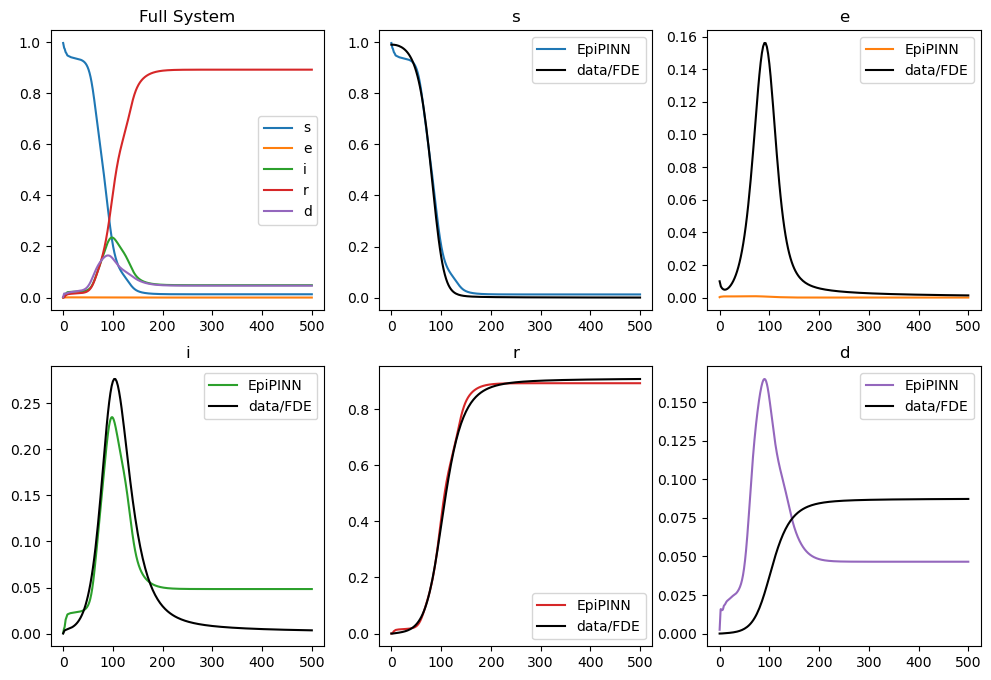

In [48]:
# Compound plot of model results, and comparison against data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
labels = ['Full System', 's', 'e', 'i', 'r', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ts_val = torch.from_numpy(np.linspace(t0, tf, 1000)).float().unsqueeze(1)
model1.eval()
with torch.no_grad():
    ys_val = model1(ts_val)

# Full system
for i in range(5):
    axs[0, 0].plot(ts_val, ys_val[:, i], label=labels[i + 1])

# Individial plots
for i in range(5):
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts_val, ys_val[:, i], label='EpiPINN', color=colors[i])
    axs[(i + 1) // 3, (i + 1) % 3].plot(ts, ys[:, i], label='data/FDE', color='k')

for i in range(6):
    axs[i // 3, i % 3].set_title(labels[i])
    axs[i // 3, i % 3].legend()

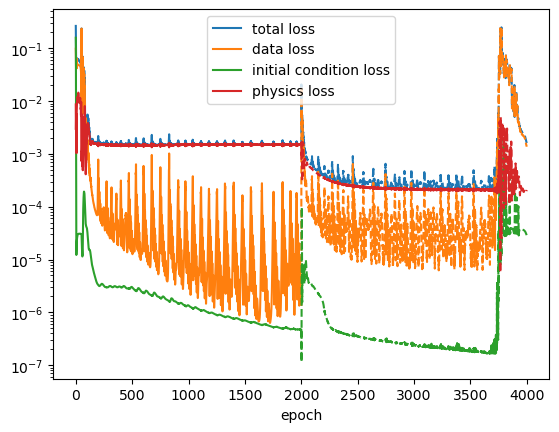

In [49]:
# Loss plot
l1 = len(losses1)
l2 = len(losses2)
epochs1 = range(l1)
epochs2 = range(l1, l1 + l2)
fig, ax = plt.subplots()
ax.semilogy(epochs1, losses1, label='total loss', color=colors[0])
ax.semilogy(epochs1, losses1_data, label='data loss', color=colors[1])
ax.semilogy(epochs1, losses1_ic, label='initial condition loss', color=colors[2])
ax.semilogy(epochs1, losses1_phys, label='physics loss', color=colors[3])
ax.semilogy(epochs2, losses2, color=colors[0], ls='--')
ax.semilogy(epochs2, losses2_data, color=colors[1], ls='--')
ax.semilogy(epochs2, losses2_ic, color=colors[2], ls='--')
ax.semilogy(epochs2, losses2_phys, color=colors[3], ls='--')
ax.set_xlabel('epoch')
ax.legend()

Text(0.5, 1.0, 'mu')

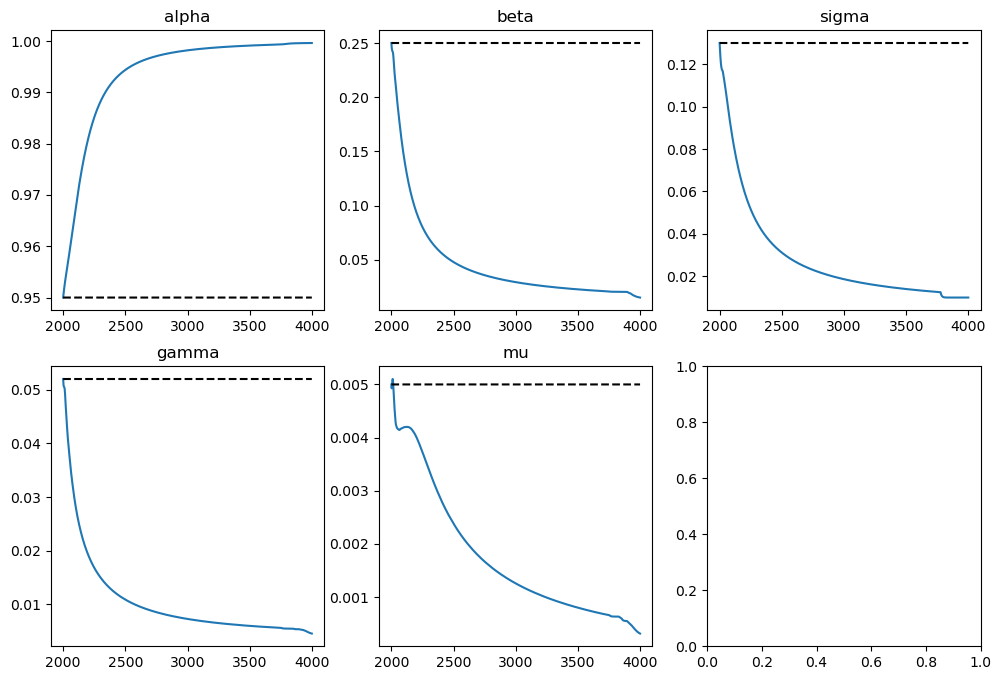

In [50]:
 # Parameter convergence
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].plot(epochs2, alphas)
axs[0, 0].plot(epochs2, alpha_true * np.ones(l2), color='k', ls='--')
axs[0, 0].set_title('alpha')

axs[0, 1].plot(epochs2, betas)
axs[0, 1].plot(epochs2, beta_true * np.ones(l2), color='k', ls='--')
axs[0, 1].set_title('beta')

axs[0, 2].plot(epochs2, sigmas)
axs[0, 2].plot(epochs2, sigma_true * np.ones(l2), color='k', ls='--')
axs[0, 2].set_title('sigma')

axs[1, 0].plot(epochs2, gammas)
axs[1, 0].plot(epochs2, gamma_true * np.ones(l2), color='k', ls='--')
axs[1, 0].set_title('gamma')

axs[1, 1].plot(epochs2, mus)
axs[1, 1].plot(epochs2, mu_true * np.ones(l2), color='k', ls='--')
axs[1, 1].set_title('mu')

### Experiment 2: Parameter estimation with noisy data

This experiment is also a recreation of the Mpox synthetic case found in the paper. Now random noise is added to the data to test the model's abitilty to recover the ideal model.